# Reinforcement Learning

Ce TP concerne la découverte de l'apprentissage par renforcement appliqué au domaine du gaming. Les observations seront données par un émulateur de jeux atari. L'objectif de ce tp est la mise en oeuvre de différents algorithmes types **policy gradient**.

## 1. Setup

Import de quelques modules

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Installation de openai gym et des agents
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
    IS_COLAB = True
    try:
        import pyvirtualdisplay
        display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
    except ImportError:
        pass    
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')


# 2. Introduction to OpenAI gym

Dans ce notebook, l'environnement et les observations/données seront fournis par le framework [OpenAI gym](https://gym.openai.com/). Il fournit de nombreux environnements avec lesquels peut interagir et apprendre votre *agents*.
L'import se fait classiquement par:

In [2]:
import gym

La liste des environnements disponibles est donnée par:

In [3]:
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

Le [Cart-Pole](https://gym.openai.com/envs/CartPole-v1/) est un environnement très simple dans lequel un chariot peut bouger soit vers la gauche, soit vers la droite. Un bâton/piquet est placé sur ce dernier. L'agent doit alors bouger le chariot à gauche ou à droite pour que le bâton reste droit.
![Cartpole](./images/cartpole.jpeg)

L'environnement est défini par la commande `make()`:

In [4]:
env = gym.make('CartPole-v1')

Il faut ensuite initialiser l'environnement en appelant la méthode `reset()` qui retourne la première observation.

In [5]:
env.seed(seed)
obs = env.reset()
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

Les observations dépendent de l'environnement considéré. Dans ce cas, les observations sont regroupées dans un array Numpy 1D soit 1 vecteur composé de 4 floats. Ce vecteur regroupe:
- la position horizontale du chariot (<0 gauche; 0 = verticale; >0 droite)
- la vitesse du chariot  
- l'angle du bâton (<0 gauche; 0 = verticale; >0 droite)
- la vitesse angulaire 


Un environnement peut-être visualisé par appel à la méthode `render()`. Pour cet environnement deux modes de rendering exitents:
- si on veut récupérer les observations (sous la forme d'image), `img = env.render(mode="rgb_array")`
- ou si on veut afficher l'environnement  `env.render()`

In [6]:
env.render()

True

Pour récupérer une observation (une image) de l'environnement sous la forme d'un array NumPy:

In [7]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

La fonction `plot_environment()` permet de récupérer et d'afficher l'observation courante de l'environnement.

In [8]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

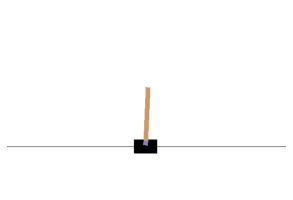

In [9]:
plot_environment(env)
plt.show()

Pour interagir avec l'environnement, l'agent doit sélectionner une action à partir de l'espace des actions possibles. Pour chaque environnement, la commande `action_space` permet de connaitre cet espace.

In [10]:
env.action_space

Discrete(2)

Pour le cartpole,deux actions sont possible: gauche ou droite. 

Dans l'état actuel, le bâton est penché vers la droite (`obs[2] > 0`); passons l'action de déplacer le chariot vers la droite.

In [11]:
# action 
action = 1  # right

# interaction with the environment
obs, reward, done, info = env.step(action)

# observation 
obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

Remarquez que:
- le chariot se déplace maintenant vers la droite (`obs[1] > 0`);
- le bâton est toujours incliné vers la droite (`obs[2] > 0`) ;
- mais sa vitesse angulaire est maintenant négative (`obs[3] < 0`), il est ainsi vraissemblable qu'il soit incliné vers la gauche après la prochaine action.

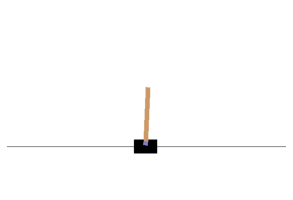

In [12]:
plot_environment(env);

L'interaction avec l'environnement:
- génère l'observation suivante obs
- renseigne l'agent sur la récompense générée par l'action prise: reward
- retourne `done=True` si le jeu est fini (pour cet environnement, le jeu est fini si l'angle du baton est de plus de 12° ou si le chariot s'est déplacé de plus 2.4 unités par rapport au centre.)
- info est un dictionnaire spécifique à chaque environnement qui peut contenir des informations supplémentaires pour le debugging ou l'apprentissage. Pour cet environnement, info est vide.

In [13]:
reward

1.0

In [14]:
done

False

In [15]:
info

{}

Comme nous l'avons vu en cours, un **épisode** correspond à la séquence d'interactions entre le moment où l'environnement est lancé `reset()` et le moment ou `done=True`. Pour relancer un épisode, il faut refaire appel à la méthode `reset()`.

In [16]:
if done:
    obs = env.reset()

**Charger consécutivement les environnements suivants:**
- **SpaceInvaders-v0**
- **CarRacing-v0**

**Déterminer pour chaque environnement:**
- **l'espace d'actions**
- **l'espace d'observation**

**et créer une image/copie de chaque environnement**

In [17]:
####################
# YOUR CODE HERE: SpaceInvaders
env1 = gym.make('SpaceInvaders-v0')

img = plot_environment(env1)
plt.show()

print('action space: {}'.format(env1.action_space))
print('observation space: {}'.format(img.shape))
env1.close()
####################


DependencyNotInstalled: No module named 'atari_py'. (HINT: you can install Atari dependencies by running 'pip install gym[atari]'.)

In [ ]:
####################
# YOUR CODE HERE: CarRacing-v0

# pip install gym[Box2D]
env2 = gym.make('CarRacing-v0')
obs = env2.reset() # attention apparemment tant que le reset n'est pas fait aucune donnée
#img = env2.render(mode="rgb_array") #["human", "rgb_array", "state_pixels"]
img = plot_environment(env2)
#plt.show()
print('action space: {}'.format(env2.action_space))
print('observation space: {}'.format(img.shape))
env2.close()
####################


# 3. Définition d'une politique simple (policy)

Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

Revenons au **CartPole** et essayons de le maintenir droit. Nous avons besoin d'une policy (politique) pour cela. Il s'agit d'une stratégie que l'agent utilisera pour sélectionner une action à chaque étape. Cette stratégie pourra utiliser potentiellement utiliser toutes les actions et observations passées pour faire cela.

Pour le moment, nous allons définir une politique très simple consistant à déplacer le chariot vers la gauche (resp. la droite) quand il penche vers la gauche (resp. la droite). Ici, la policy $\pi_{\theta}(\mathbf{a}_t|\mathbf{o}_t)$ est déterministe pourra donc s'écrire $\mathbf{a}_t = \pi(\mathbf{o}_t)$.

**Question:**
Pour l'implémentation vous créerez:
- une fonction `simple_policy(obs)` retournant l'action à prendre en fonction de l'observation
- un script qui permet de
 - générer `episode_nb` (500) épisodes (ou échantillons, trajectoires, roll_out)
 - chacun de ces épisodes comprend un nombre max d'interaction avec l'environnement fixé à `interaction_max_nb = 200`
 - pour chaque interaction, décider de l'action à prendre (appel à `simple_policy()`), jouer cette action en interagissant avec l'environnement et récupérer la reward et calculer la reward totale
 - calculer les performances de l'algorithme (les statistiques: moyenne, std, min, max)
 
 
**Notes**: deux boucles imbriquées sont à coder, vous pouvez suivre le squellette suivant


In [ ]:
# fixer la graine aléatoire
env.seed(seed)

# policy definition
def simple_policy(obs):
    

    ####################
    # YOUR CODE HERE 
    
    ####################
    return action 

# parameters
episode_nb=500
interaction_max_nb=200
episode_rewards_history=[]


####################
# YOUR CODE HERE 

# loop over the episodes
for ...
    
    # starting a new episode
    
    # ...with interaction_max_nb interactions
    for step in range(interaction_max_nb):

        # starting a new interaction
        
        # select action

        # interaction
        
        # cumulate reward

        # continue or not
        if done:
            break
            
    # performance statistics
    episode_rewards_history.append(episode_rewards)
    
####################


In [ ]:
# Display performance statistics
np.mean(episode_rewards_history), np.std(episode_rewards_history), np.min(episode_rewards_history), np.max(episode_rewards_history)


**Questions**: Quelles sont vos conclusions sur les performances obtenues?


**Your answer here**
 


Vous pouvez visualiser l'évolution du cartpole au cours d'un episode avec la boucle suivante.
**Question**:
Complétez les lignes demandées.

In [ ]:
# on fixe la graine aléatoire
env.seed(seed)

# initialisation
frames = []
obs = env.reset()

# boucle d'interactions
for step in range(interaction_max_nb):
    
    # recuperation de l'environnement courant
    img = env.render(mode="rgb_array")
    frames.append(img)
     
    # select action
    ####################
    # YOUR CODE HERE 

    ####################

    # interaction
    ####################
    # YOUR CODE HERE 

    ####################

    # continue or not
    if done:
        print('break at {}'.format(step))
        print('obs: {}'.format(obs))
        print('reward: {}'.format(reward))
        break


Vous pouvez définir un lecteur d'animation.

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
plot_animation(frames)

# 4. Neural Network Policies

Nous allons la remplacer la policy avec une stratégie trop simple en remplacant la fonction par un réseau de neurones permettant plus de liberté.

**Question**: Commencer par créer un model séquentiel de réseau de neurones à deux couches dense (la couche cachée sera de 4 neurones) avec keras:
- Ce réseau prendra une observation en entrée
- Ce réseau prédira l'action à prendre pour chaque observation. Pour choisir l'action, le réseau estimera la probabilité pour chaque action.
- Quel est le nombre de neurones de la couche de sortie? Quelle sera la fonction d'activation de la dernière couche? Pourquoi?

**Notes sur observations et états**:
Dans cet environnement particulier, les actions passées et les observations peuvent être ignorées car chaque observation contient l'état complet de l'environnement. Si par exemple, l'observation ne contenait pas la vitesse du chariot, on aurait besoin de quelques observations successives de la position du chariot pour l'estimer et répondre au problème. Si la qualité des observations était très mauvaises par exemple dans le cas de données bruitées, il faudrait probablement mettre dans les observations, quelques observations successives.


**Réponse**:
- nb de neurones 1 et fonction d'activation sera sigmoid

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(seed)
np.random.seed(seed)

####################
# YOUR CODE HERE 
model=...
####################


**Question:**
Complétez la fonction suivante vise le rendu d'un épisode et sort les frames pour afficher l'animation.

**Notes sur le compromis entre exploration et action**
Vous devez définir sous le commentaire `# exploration or action strategy` une stratégie entre choisir une action la plus probable et exploration d'une autre action. Cette approche laisse l'agent trouver le bon équilibre entre explorer de nouvelles actions et exploiter les actions qui sont connus pour bien fonctionner. Imaginer que vous alliez dans un restaurant pour la première fois et que tous les plats vous semblent de la même manière appétissants. Vous en choisissez un au hasard. S'il vous satisfait, vous allez augmenter la probabilité de le choisir à votre prochain passage dans ce restaurant. Si vous fixez cette probabilité à 1, vous n'essaierez jamais les autres plats...

Ici une stratégie simple sera:
- réaliser un tirage aléatoire uniforme d'un réell compris entre 0 et 1 
- vérifier si ce tirage est supérieur à la probabilité de déplacer le chariot vers la gauche
- l'`action` sera `False` avec la probabilité `left_proba` ou `True` avec la probabilité `1 - left_proba`
- il suffit alors de "caster" ce booléen en nombre.


In [ ]:
def render_policy_net(model, interaction_max_nb=200, seed=42):
    
    # on fixe la graine aléatoire
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)

    # initialisations
    frames = []
    obs = env.reset()

    # boucle d'interactions
    for step in range(interaction_max_nb):

        ####################
        # YOUR CODE HERE 

        # recuperation de l'environnement courant


        # select action

        
        # exploration or action strategy

        # interaction

        ####################

        # continue or not
        if done:
            break
    
    # output
    env.close()
    return frames




On peut alors voir le déroulement d'un épisode.

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

A ce stade, les poids du réseau de neurones sont aléatoires. Aucun apprentissage n'a eu lieu.
L'algorithme REINFORCE de type policy gradient nous permettra de faire cet apprentissage.


# 5. Policy Gradients

Pour entraîner ce réseau de neurones, nous devrons définir les probabilités cibles `y`. Si une action est bonne, nous devons augmenter sa probabilité, et inversement si elle est mauvaise, nous devons la réduire. Mais comment savoir si une action est bonne ou mauvaise ? Le problème est que la plupart des actions ont des effets différés, donc lorsque vous gagnez ou perdez des points dans un épisode, il n'est pas clair quelles actions ont contribué à ce résultat : était-ce seulement la dernière action ? Ou les dix dernières ? Ou une seule action 50 étapes plus tôt ? C'est ce qu'on appelle le _problème d'attribution de crédit_.

L'algorithme _Policy Gradients_ s'attaque à ce problème en jouant d'abord plusieurs épisodes, puis en rendant les actions des bons épisodes légèrement plus probables, tandis que les actions des mauvais épisodes sont rendues légèrement moins probables. On joue d'abord, puis on revient en arrière et on réfléchit à ce qu'on a fait.

Pour mémoire, la fonction de coût pour les algorithmes PG est :
	\begin{align*}
		J(\theta) &= E_{\tau \sim p_\theta(\tau)} \left[\sum\limits_{t}^T r(\mathbf{s}_{t},\mathbf{a}_{t}) \right] \approx \frac{1}{N} \sum\limits_{i=1}^N  \sum\limits_{t} r(\mathbf{s}_{i,t},\mathbf{a}_{i,t})
%		\nabla_{\theta}J(\theta) &= E_{\tau \sim p_\theta(\tau)} \left[ \left(\sum\limits_{t}^T r(\mathbf{s}_{t},\mathbf{a}_{t}) \right) \cdot \left(  \sum\limits_{t=1}^{T} \nabla_{\theta} \log \pi_\theta(\mathbf{a}_t|\mathbf{s}_t) \right) \right] 
	\end{align*}

Elle peut être estimée à partir de $N$ trajectoires
	\begin{align*}
		J(\theta) &\approx \frac{1}{N} \sum\limits_{i=1}^N \left[ \left(\sum\limits_{t=1}^T \nabla_{\theta} \log \pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t})\right) \left( \sum\limits_{t=1}^T r(\mathbf{s}_{i,t},\mathbf{a}_{i,t}) \right) \right]\\
	\end{align*}

L'algorithme d'apprentissage REINFORCE est alors:
- Sample $ \{ \tau^i\}_{i=1,\dots,N} $ from $\pi_{\theta}(\mathbf{a}_t|\mathbf{s}_t)$
- Evaluate the gradient:
\begin{align}
		\nabla_{\theta}J(\theta) &\approx \frac{1}{N} \sum\limits_{i=1}^N \left[ \left(\sum\limits_{t=1}^T \nabla_{\theta} \log \pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t})\right) \left( \sum\limits_{t=1}^T r(\mathbf{s}_{i,t},\mathbf{a}_{i,t}) \right) \right]
		\end{align}
- Update the parameters $ \theta \leftarrow \theta + \eta \nabla_{\theta} J(\theta) $

Comme mentionné en cours, nous allons bénéficier de l'algorithme de calculs automatiques du gradient offert par tensorflow. L'algorithme consiste alors à réaliser:
- générer une interaction en calculant la loss et ses gradients et gardant la reward
- générer un épisode composé d'un ensemble d'interactions
- itérer pour appliquer les gradients à la policy par `gradient ascent`

**Question**:
La loss peut ici être estimée par la fonction `tf.keras.losses.binary_crossentropy` pourquoi?


**Your Answer here:**


Commençons par créer une fonction `one_interaction` pour réaliser une seul interaction:
 - en utilisant le modèle de réseau de neurones
 - en calculant la loss et ses gradients (nous allons simplement enregistrer ces gradients pour l'instant, et les modifier plus tard en fonction de la qualité ou de la mauvaise de l'action)


Notes: 
- pour calculer un gradient avec Tensorflow (sans Keras), il faut calculer la `loss` dans le contexte `tf.GradientTape()`. Les gradients sont ainsi calculés par la méthode `gradient` (voir ci-dessous).
- `y_target` sera 1 si l'action est d'aller à gauche (=0) et 0 dans le cas contraire.
- `tf.reduce_mean(loss_fn(...)` permettra d'estimer la loss


In [ ]:
def one_interaction(env, obs, model, loss_fn):
    
    # compute gradients
    with tf.GradientTape() as tape:
      
        ####################
        # YOUR CODE HERE 
        # forward pass of the model outputs the probability of going left
        #(attention le model attend un batch d'une seule observation)

        
        # exploration or action strategy

        
        # compute losses

        ####################

    # gradient de la loss en fonction des paramètres entrainables du model
    grads = tape.gradient(loss, model.trainable_variables)
    
    # interaction
    
    # sorties
    return obs, reward, done, grads

In [ ]:
# test de la fonction
loss_fn = tf.keras.losses.binary_crossentropy
obs, reward, done, grads = one_interaction(env, obs, model, loss_fn)
obs

**Question**: Maintenant, créez une autre fonction qui s'appuiera sur la fonction `one_interaction()` pour jouer plusieurs épisodes, en retournant toutes les récompenses et les gradients, pour chaque épisode et chaque étape.

In [ ]:
def generate_multiple_episodes(env, episode_nb, interaction_max_nb, model, loss_fn):

    ####################
    # YOUR CODE HERE 

    # initialisation
 

    # episode loop
    for episode ...
        
        # initialisation

        # interaction loop
        for interaction ...:
            
            # interaction
            
            # update current rewards and grads
            
            # continue episode or not
            if done:
                break
 

        # update rewards and grads histories
    
    ####################

    # outputs
    return rewards_hist, grads_hist

In [ ]:
# test de la fonction
loss_fn = tf.keras.losses.binary_crossentropy
episode_nb = 3
rewards_hist, grads_hist = generate_multiple_episodes(env, episode_nb, interaction_max_nb, model, loss_fn)
print('rewards:', rewards_hist[0])

print('grads:', grads_hist[0])

L'algorithme PG utilise le modèle pour jouer l'épisode plusieurs fois (par exemple 10 fois), puis il revient en arrière et examine toutes les récompenses pour calculer:
- la "reward-to-go" avec un "discount" facteur:
\begin{align*}
\nabla_{\theta}J(\theta) &\approx \frac{1}{N} \sum\limits_{i=1}^N \left[ \sum\limits_{t=1}^{T} \left( \nabla_{\theta} \log \pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t}) \cdot  \sum\limits_{t'=t}^T \gamma^{t'-t} r(\mathbf{s}_{i,t'},\mathbf{a}_{i,t'}) \right) \right]
\end{align*}	
- la "reward-to-go" avec une baseline moyenne.
 \begin{align*}
\nabla_{\theta}J(\theta) &\approx \frac{1}{N} \sum\limits_{i=1}^N \left[ \sum\limits_{t=1}^{T} \left( \nabla_{\theta} \log \pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t}) \cdot  \left(\sum\limits_{t'=t}^T  \gamma^{t'-t} r(\mathbf{s}_{i,t'},\mathbf{a}_{i,t'}) - b\right) \right)\right]\\
b &= \frac{1}{N}\sum\limits_{i=1}^{N} R(\tau)
\end{align*}	

- la "reward-to-go" avec une baseline moyenne et normalisation par un ecart type.
 \begin{align*}
\nabla_{\theta}J(\theta) &\approx \frac{1}{N} \sum\limits_{i=1}^N \left[ \sum\limits_{t=1}^{T} \left( \nabla_{\theta} \log \pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t}) \cdot  \frac{\left(\sum\limits_{t'=t}^T \gamma^{t'-t}  r(\mathbf{s}_{i,t'},\mathbf{a}_{i,t'})\right) - b }{s}\right) \right]\\
b &= \frac{1}{N}\sum\limits_{i=1}^{N} R(\tau) \;\;\;\;\; s = std
\end{align*}	

Ces différentes fonctions "reward-to-go" servent à réduire la variance de l'estimateur du gradient connu pour être très bruité. Leur expression sont respectivement 


**Question**: Créez quatre fonctions permettant à partir d'une liste de rewards de sortir les trois types de reward:
- la première `compute_discounted_rewards` calculera les récompenses réduites (entrées: liste de rewards et discount_rate)
- la seconde `episode_discounted_rewards` calculera les récompenses réduites moins la moyenne sur de nombreux épisodes (entrées: liste de listes de rewards et discount_rate).
- la troisième `episode_discounted_rewards_mean` calculera les récompenses réduites moins la moyenne sur de nombreux épisodes.(entrées: liste de listes de rewards et discount_rate).
- la quatière `episode_discounted_rewards_mean_std` normalisera les récompenses réduites sur de nombreux épisodes.(entrées: liste de listes de rewards et discount_rate).

In [ ]:
def compute_discounted_rewards(rewards, discount_rate):
    ####################
    # YOUR CODE HERE 

    ####################

    return discounted

def episode_discounted_rewards(all_rewards, discount_rate):
    ####################
    # YOUR CODE HERE 

    ####################
    return all_discounted_rewards 


def episode_discounted_rewards_mean(all_rewards, discount_rate):
    ####################
    # YOUR CODE HERE 

    ####################
    return all_discounted_rewards

def episode_discounted_rewards_mean_std(all_rewards, discount_rate):
    ####################
    # YOUR CODE HERE 

    ####################
    return all_discounted_rewards


In [ ]:
#Test de la fonction (on doit obtenir array([-22, -40, -50]))
compute_discounted_rewards([10, 0, -50], discount_rate=0.8)

In [ ]:
#Test de la fonction (on doit obtenir [array([-22., -40., -50.]), array([26., 20.])])
episode_discounted_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

In [ ]:
#Test de la fonction (on doit obtenir [array([ -8.8, -26.8, -36.8]), array([39.2, 33.2])])
episode_discounted_rewards_mean([[10, 0, -50], [10, 20]], discount_rate=0.8)

In [ ]:
#Test de la fonction (on doit obtenir [array([-0.28435071, -0.86597718, -1.18910299]),array([1.26665318, 1.0727777 ])]
episode_discounted_rewards_mean_std([[10, 0, -50], [10, 20]], discount_rate=0.8)

Finalement, on a tous les blocs pour l'algorithme final que vous compléterez.

In [ ]:
# parametres
n_iterations = 150
episode_nb_per_update = 10
interaction_max_nb = 200
discount_rate = 0.95

In [ ]:
# optimiseur
optimizer = keras.optimizers.Adam(lr=0.01)

# loss fonction
loss_fn = keras.losses.binary_crossentropy

In [ ]:
# model
keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

####################
# YOUR CODE HERE 
model = ...
####################


In [ ]:
# initialisation
env = gym.make("CartPole-v1")
env.seed(seed);

# gradient descent loop
for iteration in range(n_iterations):
  
    ####################
    # YOUR CODE HERE 

    # generate samples for on policy algorithm through multiple episodes

    # performances
    total_rewards = sum(map(sum, all_rewards))                     
    print("\rIteration: {}, mean rewards: {:.1f}".format(          
        iteration, total_rewards / episode_nb_per_update), end="") 
    
    # compute discounted reward rewards
    
    # compute gradients weighted by discounted reward-to-go
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    # apply gradients to policy
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

**Question**: Testez les trois différentes fonctions *reward-to-go* et comparez leurs performances.

## 6. (Optionnel) Testez l'algorithme en l'adaptant pour un autre environnement de votre choix